In [1]:
import csv
import pandas as pd
import numpy as np

df=pd.read_csv('/home/lavykoilpitchai/Dropbox/UU_Master/project_datascience/Bayessian_regressors_backup/data/fashion-mnist_train.csv')
df_test = pd.read_csv('/home/lavykoilpitchai/Dropbox/UU_Master/project_datascience/Bayessian_regressors_backup/data/fashion-mnist_test.csv')


mean=df.iloc[:, 1:].mean().mean()
std=df.iloc[:, 1:].std().mean()
df_norm=(df.iloc[:, 1:]-mean)/std
df_norm.insert(0, 'label', df['label'])
df_test = pd.read_csv('/home/lavykoilpitchai/Dropbox/UU_Master/project_datascience/Bayessian_regressors_backup/data/fashion-mnist_test.csv')
df_test_norm=(df_test.iloc[:, 1:]-mean)/std
df_test_norm.insert(0, 'label', df_test['label'])

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images from the DataFrame
def display_images(df, indices, figsize=(12, 8)):
    
    n_images = len(indices)
    cols = min(5, n_images)  # Maximum 5 columns
    rows = (n_images + cols - 1) // cols  # Calculate rows needed
    
    plt.figure(figsize=figsize)
    
    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)
        
        # Get the label and pixel data
        label = df.iloc[idx, 0]
        pixels = df.iloc[idx, 1:].values
        image = pixels.reshape(28, 28)
        
        plt.imshow(image, cmap='gray')
        plt.title(f'Index: {idx}, Label: {label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
# class names 
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']    


Displaying one example from each class:


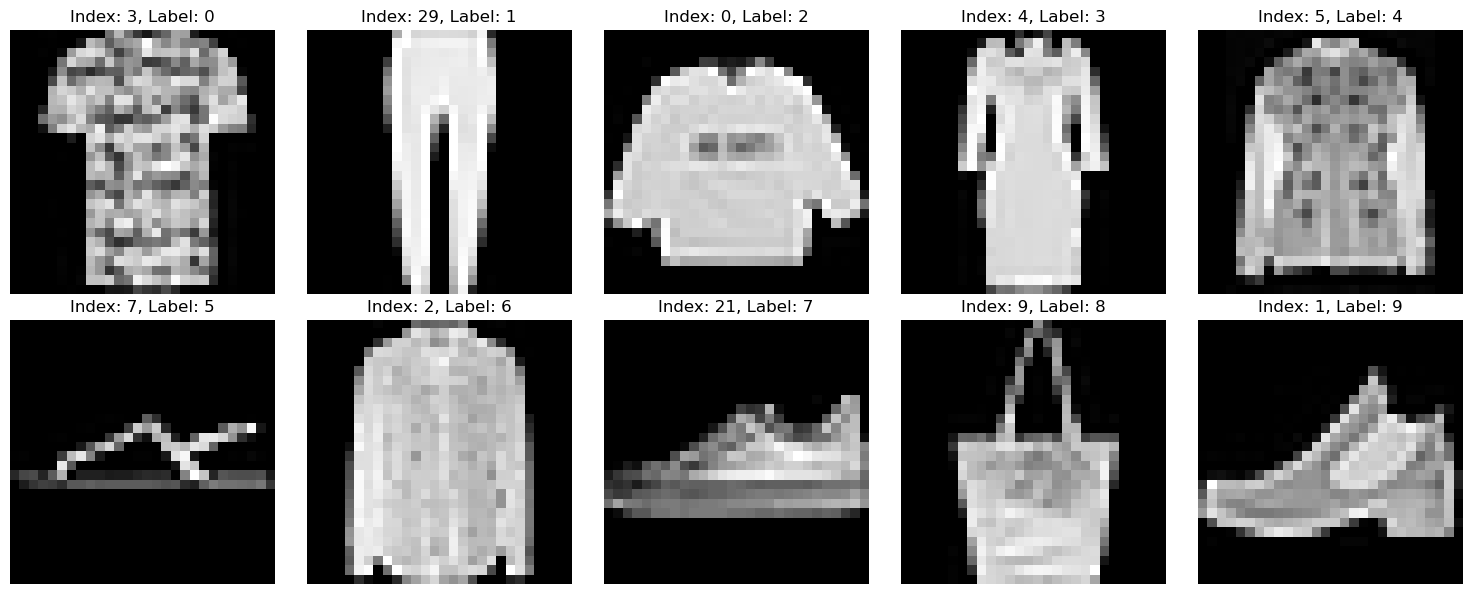

In [3]:
print("\nDisplaying one example from each class:")
one_per_class = []
for class_label in range(10):
    # collect indices of first occurrence of each class
    class_indices = df[df['label'] == class_label].index
    if len(class_indices) > 0:
        one_per_class.append(class_indices[0])
#display images 
display_images(df, one_per_class, figsize=(15, 6))        

In [4]:
def hide_continuous(df, hide=[0.25, 0.75], hidden_value=0):
    """
    Hides a percentage of pixels in a dataframe 
    and returns two dataframes with different masking levels.

    Args:
        df: Input dataframe
        hide (list): List of two hiding ratios
        hidden_value: The value to replace the hidden pixels with.

    Returns:
        tuple: (df_first, df_second) - Two dataframes with the specified hiddden value applied.
    """
    # Set random seed for reproducibility
    np.random.seed(42)

    labels = df.iloc[:, 0].to_numpy()
    original_pixels = df.iloc[:, 1:].to_numpy(copy=True)  #copy to avoid modifying original df
    n_rows, n_pixels = original_pixels.shape
    
    hide_first_ratio = hide[0]
    hide_second_ratio = hide[1]

    #Calculate the number of pixels to hide for each ratio
    n_hide_first = int(n_pixels * hide_first_ratio)
    n_hide_second = int(n_pixels * hide_second_ratio)

    

    #Select indices to hide. We select the indices for the larger ratio first,
    # then use a subset of those for the smaller ratio.
    all_drop_indices = np.random.choice(
        n_pixels, 
        size=n_hide_second, 
        replace=False
    )
    
    # Indices for the smaller mask
    # Take the first n_hide_first elements of the larger set
    drop_indices_first = all_drop_indices[:n_hide_first] 
    
    # Indices for the larger mask 
    drop_indices_second = all_drop_indices 

    # first dataframe
    pixels_first = original_pixels.copy()
    # Mask rows at the selected columns
    pixels_first[:, drop_indices_first] = hidden_value 
    
    df_first = pd.DataFrame(
        pixels_first, 
        columns=df.columns[1:], 
        index=df.index
    )
    df_first.insert(0, 'label', labels)
    
    # second dataframe
    pixels_second = original_pixels.copy()
    # Mask all rows at the selected columns
    pixels_second[:, drop_indices_second] = hidden_value
    
    df_second = pd.DataFrame(
        pixels_second, 
        columns=df.columns[1:], 
        index=df.index
    )
    df_second.insert(0, 'label', labels)
    
    return df_first, df_second

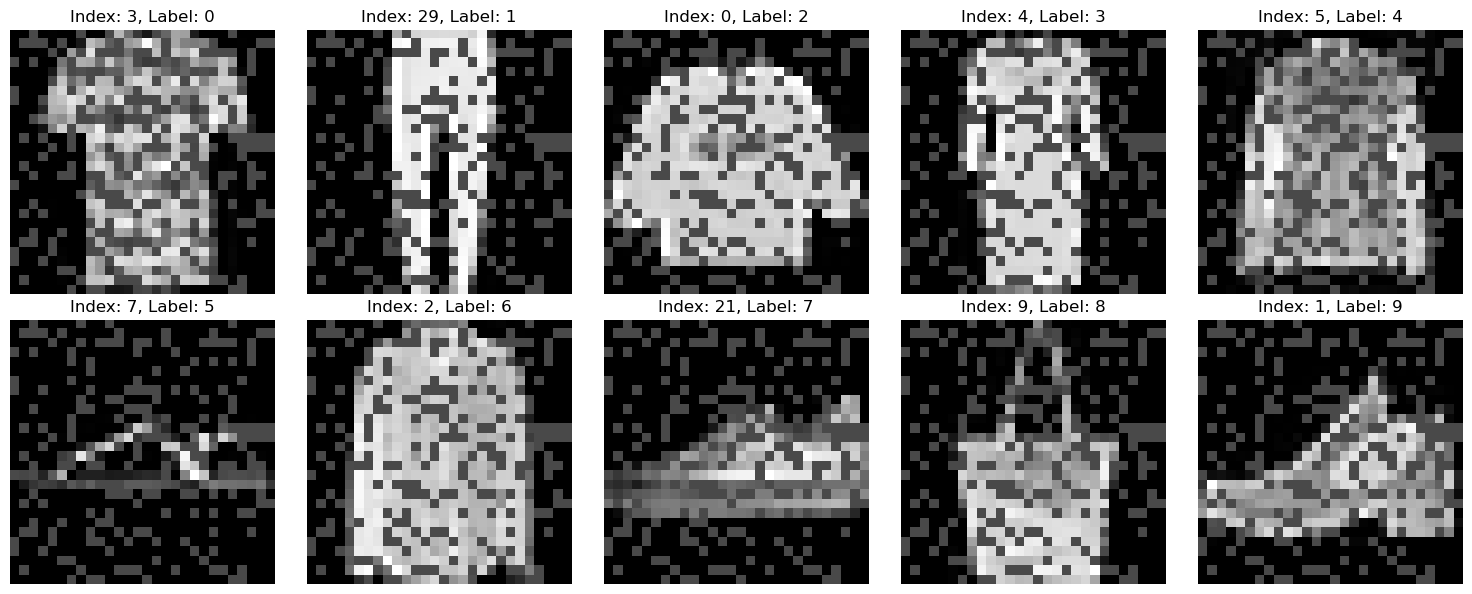

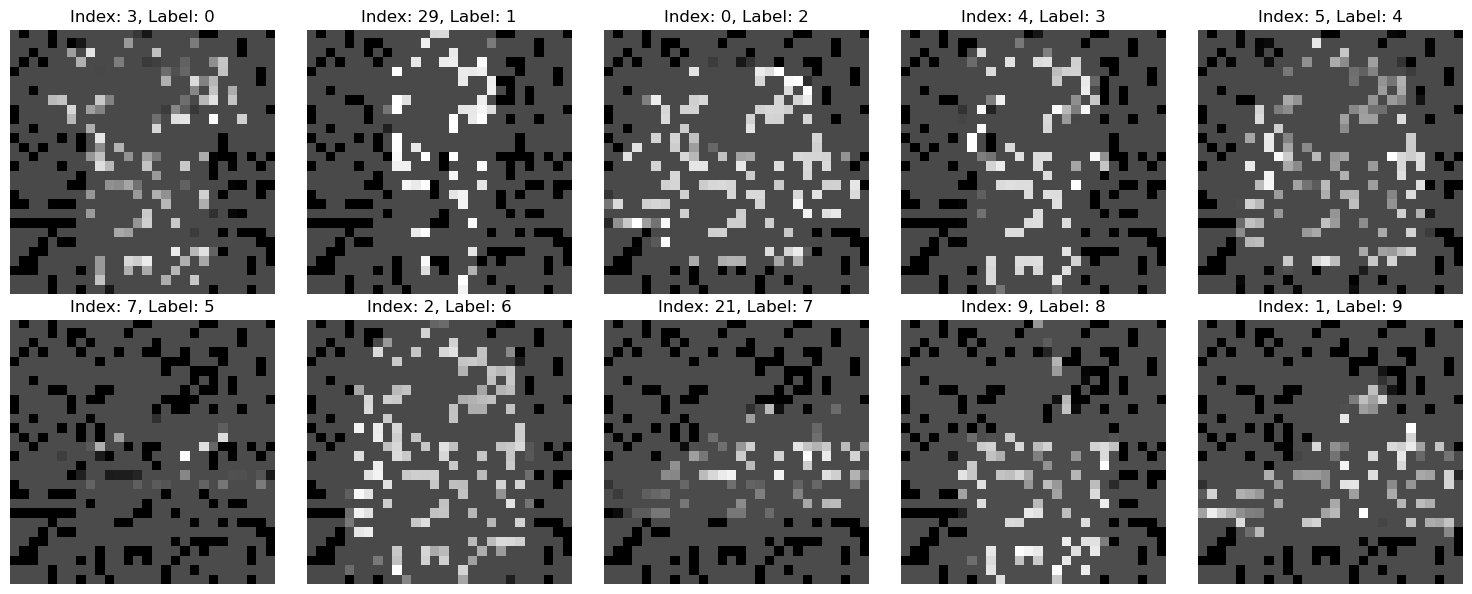

In [5]:
# original vs hidden comparison
df_cont1,df_cont2 = hide_continuous(df_norm, hide=[0.25, 0.75], hidden_value=0)

#display images     
display_images(df_cont1, one_per_class, figsize=(15, 6))
display_images(df_cont2, one_per_class, figsize=(15, 6))

## Bayesian Logistic Regression

In [6]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

# Prepare data for modeling
X_train=df_cont2.iloc[:, 1:]
y_train=df_cont2['label']
X_test=df_test.iloc[:, 1:]
y_test=df_test['label']
X_tr = X_train.to_numpy(dtype=np.float32)
X_te = X_test.to_numpy(dtype=np.float32)
y_tr = y_train.to_numpy()
y_te = y_test.to_numpy()

# Standardize features 
scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_te_s = scaler.transform(X_te)

# Get number of features and classes
n_features = X_tr_s.shape[1]
n_classes = len(np.unique(y_tr))

# Ensure labels are 0..K-1 integers
classes, y_tr_enc = np.unique(y_tr, return_inverse=True)
class_to_index = {c: i for i, c in enumerate(classes)}
y_te_enc = np.vectorize(class_to_index.get)(y_te)

# Stabilize inputs: replace NaN/inf and clip extremes
X_tr_s = np.nan_to_num(X_tr_s, nan=0.0, posinf=0.0, neginf=0.0)
X_te_s = np.nan_to_num(X_te_s, nan=0.0, posinf=0.0, neginf=0.0)
X_tr_s = np.clip(X_tr_s, -10.0, 10.0)
X_te_s = np.clip(X_te_s, -10.0, 10.0)

print("Cleaned inputs. Any NaN?", np.isnan(X_tr_s).any() or np.isnan(X_te_s).any())
print(f"n_features={n_features}, n_classes={n_classes}")

# PyMC multinomial logistic regression with ADVI
with pm.Model() as blr_model:
    
    X_data = pm.Data("X_tr", X_tr_s.astype("float32"))
    y_data = pm.Data("y_tr", y_tr_enc.astype("int32"))

    W = pm.Normal("W", mu=0.0, sigma=0.3, shape=(n_features, n_classes))
    b = pm.Normal("b", mu=0.0, sigma=0.3, shape=(n_classes,))

    logits = pm.math.dot(X_data, W) + b  # shape: (n_samples, n_classes)
    logits = pm.math.clip(logits, -20.0, 20.0)
    p = pm.math.softmax(logits, axis=1)

    y_obs = pm.Categorical("y_obs", p=p, observed=y_data)

    approx = pm.fit(
        n=3000,
        method="advi",
        obj_optimizer=pm.adamax(learning_rate=5e-3),
        callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-3)],
        random_seed=42,
        progressbar=True
    )
    trace = approx.sample(1000, random_seed=42)



Cleaned inputs. Any NaN? False
n_features=784, n_classes=10


Output()

Finished [100%]: Average Loss = 73,350


In [7]:
# Posterior means
W_mean = trace.posterior["W"].mean(dim=("chain", "draw")).values
b_mean = trace.posterior["b"].mean(dim=("chain", "draw")).values

# Predict on test
logits_te = X_te_s.astype("float32") @ W_mean + b_mean  # (n_test, n_classes)
logits_te = np.clip(logits_te, -20.0, 20.0)
p_te = np.exp(logits_te - logits_te.max(axis=1, keepdims=True))
p_te /= p_te.sum(axis=1, keepdims=True)
y_pred = p_te.argmax(axis=1)

print("Accuracy:", accuracy_score(y_te_enc, y_pred))
print(classification_report(y_te_enc, y_pred))
print(confusion_matrix(y_te_enc, y_pred))

Accuracy: 0.4827
              precision    recall  f1-score   support

           0       0.42      0.97      0.58      1000
           1       0.80      0.81      0.80      1000
           2       0.33      0.89      0.49      1000
           3       0.84      0.18      0.30      1000
           4       0.21      0.02      0.03      1000
           5       1.00      0.05      0.10      1000
           6       0.00      0.00      0.00      1000
           7       0.59      0.94      0.73      1000
           8       0.39      0.69      0.50      1000
           9       0.85      0.29      0.43      1000

    accuracy                           0.48     10000
   macro avg       0.54      0.48      0.40     10000
weighted avg       0.54      0.48      0.40     10000

[[970   3  21   0   0   0   1   1   4   0]
 [178 807  12   2   0   0   0   0   0   1]
 [102   2 890   0   1   0   0   0   5   0]
 [559 182  66 183   6   0   1   0   3   0]
 [ 46  12 902  22  16   0   0   0   2   0]
 [  9   0

## Postrior predictive distribution

In [8]:

def posterior_predictive_probs(trace, X_test):
    """
    Calculate posterior predictive mean probabilities and std dev for test data.

    Args:
        trace: The PyMC trace object.
        X_test: The test data (pandas DataFrame or numpy array).

    Returns:
        tuple: (mean_probs, std_probs) both as np.ndarray with shape (n_test, n_classes).
    """
    clip_logit = (-20.0, 20.0)
    # Accept DataFrame or numpy array input
    if hasattr(X_test, 'to_numpy'):
        X = X_test.to_numpy(dtype=np.float64)
    else:
        X = np.asarray(X_test, dtype=np.float64)

    # Extract posterior samples for W and b
    W_arr = trace.posterior['W'].values
    b_arr = trace.posterior['b'].values

    # Reshape samples
    n_chains, n_draws = W_arr.shape[:2]
    n_posterior_samples = int(n_chains * n_draws)
    W_samples = W_arr.reshape((n_posterior_samples, W_arr.shape[2], W_arr.shape[3]))
    b_samples = b_arr.reshape((n_posterior_samples, b_arr.shape[2]))

    n_test = X.shape[0]
    n_classes = W_arr.shape[3]

    #  compute  sums and sums of squares to get mean and std 
    sum_probs = np.zeros((n_test, n_classes), dtype=np.float64)
    sumsq_probs = np.zeros((n_test, n_classes), dtype=np.float64)

    for i in range(n_posterior_samples):
        logits = X @ W_samples[i] + b_samples[i]
        logits = np.clip(logits, clip_logit[0], clip_logit[1])
        exp = np.exp(logits - logits.max(axis=1, keepdims=True))
        probs = exp / exp.sum(axis=1, keepdims=True)
        sum_probs += probs
        sumsq_probs += probs * probs

    mean_probs = sum_probs / float(n_posterior_samples)
    mean_sqs = sumsq_probs / float(n_posterior_samples)
    var_probs = mean_sqs - mean_probs * mean_probs
    # numerical stability
    var_probs = np.maximum(var_probs, 0.0)
    std_probs = np.sqrt(var_probs)
    return mean_probs, std_probs




In [9]:
mean_probs, std_probs = posterior_predictive_probs(trace, X_te_s)
most_likely_class = mean_probs.argmax(axis=1)

# Calculate accuracy
accuracy = np.mean(most_likely_class == y_te_enc)
print("Posterior Predictive Accuracy:", accuracy)


Posterior Predictive Accuracy: 0.5316


## Visualize the model

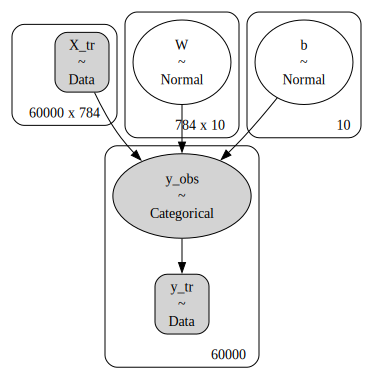

In [10]:
pm.model_to_graphviz(blr_model)